Define Directories

In [1]:
# Define directories
dataset_path = "Lung Disease Dataset"
train_dir = f"{dataset_path}/train"
val_dir = f"{dataset_path}/val"
test_dir = f"{dataset_path}/test"

Data Checking

In [2]:
import os

# Define the directory path
directory = 'Lung Disease Dataset/train'

def explore_directory(directory):
    """
    Function to explore the contents of a directory and provide insights.
    """
    if not os.path.exists(directory):
        print(f"The directory {directory} does not exist.")
        return
    
    print(f"Exploring contents of: {directory}\n")
    
    # Initialize counters
    num_dirs = 0
    num_files = 0
    dir_details = []
    
    # Walk through the directory
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            num_dirs += 1
            # Count files in each subdirectory
            num_files_in_dir = len([f for f in os.listdir(item_path) if os.path.isfile(os.path.join(item_path, f))])
            dir_details.append((item, num_files_in_dir))
        elif os.path.isfile(item_path):
            num_files += 1

    # Output the summary
    print(f"Summary:\n- Total directories: {num_dirs}\n- Total files: {num_files}\n")
    
    # Display detailed information about each subdirectory
    if dir_details:
        print("Directory details:")
        for dir_name, file_count in dir_details:
            print(f"  - {dir_name}: {file_count} files")
    else:
        print("No subdirectories found.")
    
    # List files in the root directory, if any
    root_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    if root_files:
        print("\nFiles in the root directory:")
        for file in root_files:
            print(f"  - {file}")

# Call the function to explore the directory
explore_directory(directory)

Exploring contents of: Lung Disease Dataset/train

Summary:
- Total directories: 5
- Total files: 0

Directory details:
  - Bacterial Pneumonia: 1205 files
  - Corona Virus Disease: 1218 files
  - Normal: 1207 files
  - Tuberculosis: 1220 files
  - Viral Pneumonia: 1204 files


Preprocessing

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Image size and batch size
image_size = (224, 224)
batch_size = 64

# Define transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset loading
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

Class Distribution

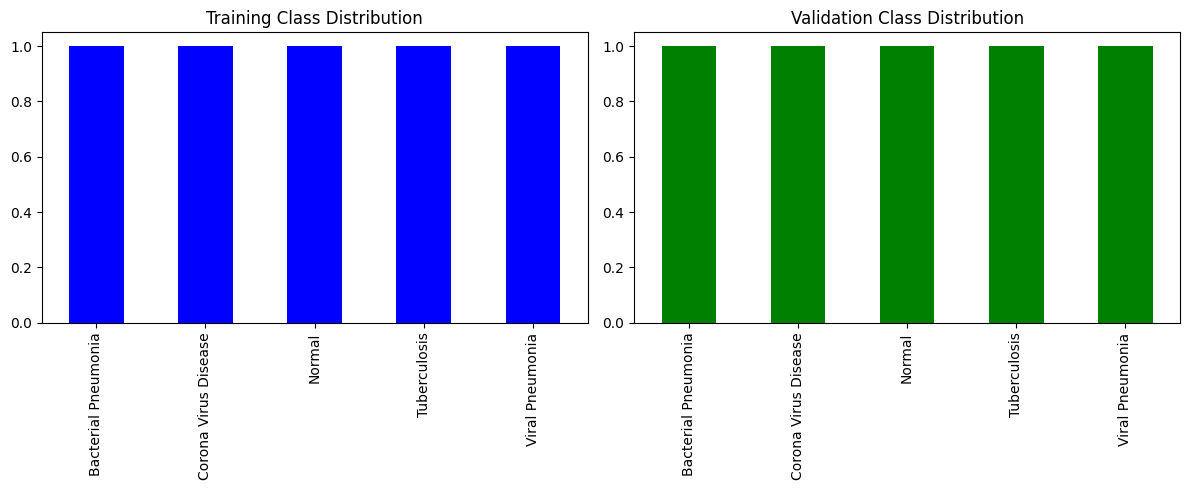

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_class_distribution(train_dataset, val_dataset):
    # Training class distribution
    train_counts = pd.Series(train_dataset.classes).value_counts()

    # Validation class distribution
    val_counts = pd.Series(val_dataset.classes).value_counts()

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    train_counts.plot(kind='bar', ax=ax[0], title='Training Class Distribution', color='blue')
    val_counts.plot(kind='bar', ax=ax[1], title='Validation Class Distribution', color='green')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_class_distribution(train_dataset, val_dataset)

Model Architecture

In [5]:
import torch.nn as nn
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNModel, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(16 * 28 * 28, 256)  # Adjust based on image size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)  # Flatten the output of conv layers
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Instantiate model
model = CNNModel(num_classes=5)


Settings

In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np

# Hyperparameters and settings
learning_rate = 0.001
num_epochs = 30

# Model setup (assuming `model` is already defined)
# Example: model = YourModel()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the learning rate scheduler function
def scheduler(epoch):
    if epoch < 10:
        return 1.0  # Keep the learning rate unchanged for the first 10 epochs
    else:
        return np.exp(-0.1 * (epoch - 10))  # Decay the learning rate exponentially after 10 epochs

# Learning rate scheduler
scheduler_lambda = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')  # Initialize with a very high loss value
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:  # Only save if the new loss is smaller
            if self.verbose:
                print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...")
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        torch.save(model.state_dict(), self.path)

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, verbose=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print("✅ CUDA is available. Using GPU.")
else:
    print("⚠️ CUDA is not available. Using CPU instead.")
    
model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


✅ CUDA is available. Using GPU.


Training

In [7]:
import time

# Training function
def train_model(model, train_loader, val_loader, num_epochs=num_epochs):
    best_val_acc = 0.0
    global train_losses, val_losses, train_accuracies, val_accuracies

    for epoch in range(num_epochs):
        start_time = time.time()  # Record the start time of the epoch
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Train loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training accuracy
        train_acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_losses.append(val_loss / len(val_loader))        
        val_accuracies.append(val_acc)
        
        scheduler_lambda.step()
        
        # Calculate and log the time spent in this epoch
        epoch_time = time.time() - start_time  # Time spent in the epoch
        epoch_minutes = epoch_time // 60
        epoch_seconds = epoch_time % 60
        
        # Log metrics with time spent
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"LR: {scheduler_lambda.get_last_lr()[0]:.6f}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Acc: {val_acc:.2f}%, "
              f"Time: {int(epoch_minutes)}m {int(epoch_seconds)}s")
        
        # Save model and check early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        early_stopping(val_loss / len(val_loader), model)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

# Start training
train_model(model, train_loader, val_loader)


Epoch [1/30], LR: 0.001000, Train Loss: 1.6685, Train Acc: 56.33%, Val Loss: 2.0631, Val Acc: 50.40%, Time: 1m 13s
Validation loss decreased (inf --> 2.063113). Saving model...
Epoch [2/30], LR: 0.001000, Train Loss: 0.9009, Train Acc: 64.07%, Val Loss: 0.7318, Val Acc: 72.02%, Time: 1m 10s
Validation loss decreased (2.063113 --> 0.731768). Saving model...
Epoch [3/30], LR: 0.001000, Train Loss: 0.7975, Train Acc: 67.86%, Val Loss: 0.7766, Val Acc: 70.19%, Time: 1m 7s
EarlyStopping counter: 1 out of 10
Epoch [4/30], LR: 0.001000, Train Loss: 0.8561, Train Acc: 68.24%, Val Loss: 0.9335, Val Acc: 61.56%, Time: 1m 4s
EarlyStopping counter: 2 out of 10
Epoch [5/30], LR: 0.001000, Train Loss: 0.7739, Train Acc: 70.25%, Val Loss: 0.7168, Val Acc: 72.32%, Time: 0m 59s
Validation loss decreased (0.731768 --> 0.716808). Saving model...
Epoch [6/30], LR: 0.001000, Train Loss: 0.7195, Train Acc: 72.40%, Val Loss: 0.6634, Val Acc: 74.75%, Time: 1m 0s
Validation loss decreased (0.716808 --> 0.66343

Testing

In [8]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

all_labels = []  # To store all true labels
all_preds = []   # To store all predicted labels

# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0  # To track total loss during testing

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions and accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
             # Append true and predicted labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_acc = 100 * correct / total
    avg_loss = total_loss / len(test_loader)  # Average test loss
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Call the test function
test_model(model, test_loader)


Test Loss: 0.5160, Test Accuracy: 80.05%


Plotting Training and Validation Metrics

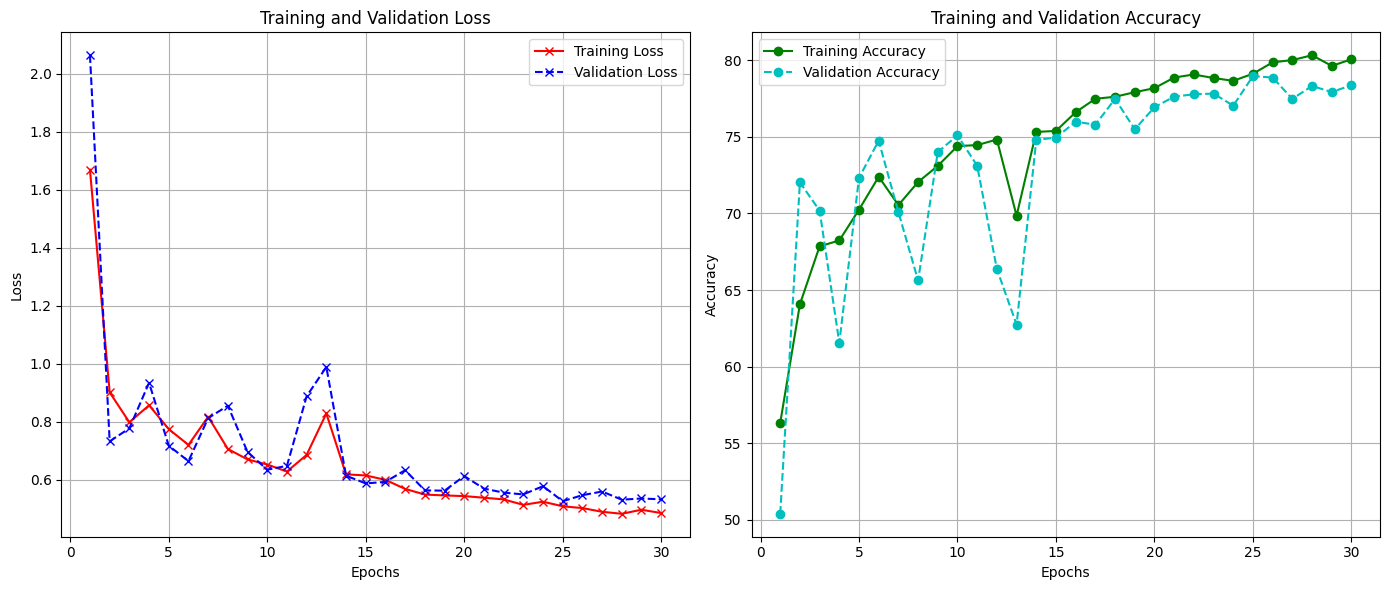

In [9]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot training and validation loss on the first subplot
    ax1.plot(epochs, train_losses, 'r-x', label='Training Loss')
    ax1.plot(epochs, val_losses, 'b--x', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')
    ax1.grid(True)

    # Plot training and validation accuracy on the second subplot
    ax2.plot(epochs, train_accuracies, 'g-o', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'c--o', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')
    ax2.grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
# Assume train_losses, val_losses, train_accuracies, and val_accuracies are defined from your training loop
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


Classification Report

In [10]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.7147    0.6278    0.6684       403
           1     0.8665    0.9410    0.9022       407
           2     0.8704    0.8812    0.8758       404
           3     0.9430    0.8922    0.9169       408
           4     0.6106    0.6576    0.6332       403

    accuracy                         0.8005      2025
   macro avg     0.8010    0.7999    0.7993      2025
weighted avg     0.8016    0.8005    0.7998      2025



Plotting Confusion Matrix

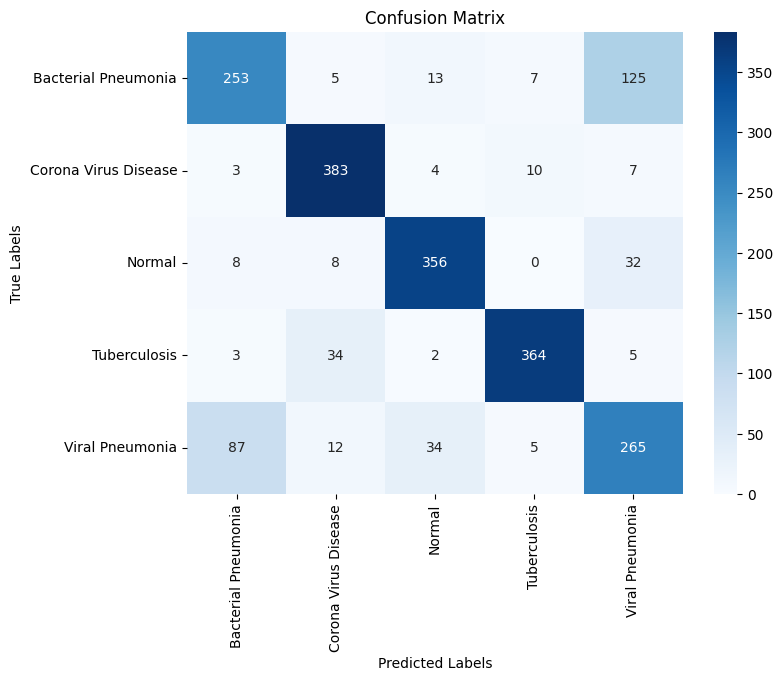

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_loader.dataset.classes, 
            yticklabels=train_loader.dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()